# Options Data Scraping and Strategy Analysis



The purpose of this notebook is to review webscraping with BeautifulSoup4 and Selenium and to implement the data in options-related trading strategies. We end by performing some analysis on the volatility of the underlying security.


### Contents:
1. [Web-scraping the option chain](#web-scraping)

2. [Other Necessary Functions/Concepts](#helper-functions)

3. [Defining our strategy class](#strat-class)

4. [Implementation Example](#example)

5. [Monte Carlo analysis](#analysis)

6. [Conclusion](#conclusion)


In [3]:
import requests 
import pandas as pd

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import warnings
warnings.filterwarnings("ignore")

<a id='web-scraping'></a>

## Webscraping
For this exercise, we will be using the BeautifulSoup and Selenium libraries. Selenium is key so that we can navigate to a website with Javascript and tease out the HTML we are looking for.



The function defined in the next cell will use Selenium to navigate to barchart.com and retrieve option chain data given specified parameter values. Note that to use selenium, we need to download a webdriver that allows for automation of webpage navigation. As I prefer Chrome, I use ChromeDriver, which can be downloaded here (depending on version): https://chromedriver.chromium.org/downloads

In [4]:
def option_chain(ticker, exp_date, volume_screen=0, oi_screen=0, timeout=30):
    """ 
    returns option chain in the form of a dataframe
    ticker: desired underlying ticker as string. "SPY" for example
    exp_date: Desired option chain expiration date. Must be in the format YYYY-mm-dd 
    volume_screen: filter out strikes that have volume below the threshold
    oi_screen: filter out strikes that have open interest below the threshold
    timeout: specifies the period in seconds to wait for webpage response
    """
    chrome_options = Options()
    driver = webdriver.Chrome(options=chrome_options) 
    try:
        url = f"https://www.barchart.com/etfs-funds/quotes/{ticker}/options?expiration={exp_date}-m&moneyness=allRows" # for IVP
        driver.get(url)
        
        # check for webpage response
        try:
            element_present = EC.presence_of_element_located((By.ID, "main-content-column"))
            my_elem = WebDriverWait(driver, timeout).until(element_present)
        except TimeoutException:
            print("Loading took too much time!")

        # get the underlying HTML 
        dom = driver.page_source
        soup = BeautifulSoup(dom, "lxml")
        
        # URL requires monthly/weekly specification. Try monthly first, then weekly.
        first_string = soup.find_all("div", {"class": "middleware-wrapper"})[0].get_text().replace("\n", "")
        data_string = first_string.replace(" ", "").replace("N/A", "")  # strip of unnecessary chars
        if data_string[-8:] == "expired.":  
            print(f"Could not find monthly for {ticker} on {exp_date}. Trying Weekly.")
            url = f"https://www.barchart.com/etfs-funds/quotes/{ticker}/options?expiration={exp_date}-w&moneyness=allRows" 
            driver.get(url)
            try:
                element_present = EC.presence_of_element_located((By.ID, "main-content-column"))
                my_elem = WebDriverWait(driver, timeout).until(element_present)
            except TimeoutException:
                print("Loading took too much time!")          
                
            dom = driver.page_source
            soup = BeautifulSoup(dom, "lxml")
            
    except Exception as e:
        print(f"Trouble gathering data -- {e}")
        driver.quit()
        
    driver.quit()
    
    # Use BeautifulSoup to scrape data
    tables = soup.find_all("div", {"class": "barchart-content-block"})
    cols = ["strike", "moneyness", "bid", "midpoint", "ask", "last", "change", "pct_chg", "volume", "oi", 
            "vol/oi", "iv", "date", "links"]
    chains = []
    for i in tables:
        option_type = i.find_all("div", {"class": "block-title joined"})[0].get_text().replace("\n","")
        td = i.find_all("td")
        table_data = [t.get_text().replace("\n", "").replace("%", "").replace("+", "").replace("-","") for t in td]
        assert(len(table_data) % len(cols) == 0), "Trouble scraping data"

        table_data = [table_data[r:r+len(cols)] for r in range(0, len(table_data), len(cols))]
        df = pd.DataFrame(data=table_data, columns=cols).drop(["change", "pct_chg", "vol/oi", "date", "links"], axis=1)
        df["type"] = option_type
        chains.append(df)
    
    try:
        option_chain = pd.concat([df for df in chains], axis=0)
    except ValueError as e:
        print(f"No data from {url}")
        option_chain = None
        
    # Preprocess our data here
    option_chain["oi"] = option_chain["oi"].str.replace(",", "")
    option_chain["volume"] = option_chain["volume"].str.replace(",", "")
    for c in option_chain.columns:
        if c != "type":
            option_chain[c] = pd.to_numeric(option_chain[c], errors="coerce")
        
    option_chain = option_chain.dropna().reset_index(drop=True)
    option_chain["iv"] /= 100
    option_chain["moneyness"] /= 100  

    # Separate calls from puts and returns
    calls = option_chain.loc[option_chain["type"] == "Calls"][["strike", "bid", "midpoint", "ask", "iv", "volume", "oi"]]
    puts = option_chain.loc[option_chain["type"] == "Puts"][["strike", "bid", "midpoint", "ask", "iv", "volume", "oi"]]

    calls = calls.loc[(calls["volume"] >= volume_screen) & (calls["oi"] >= oi_screen)]
    puts = puts.loc[(puts["volume"] >= volume_screen) & (puts["oi"] >= oi_screen)]

    return calls, puts

Now let's run the function, look at the call option chain


In [5]:
calls, puts = option_chain(ticker="QQQ", exp_date="2021-07-16", volume_screen=10)
calls.head()

,strike,bid,midpoint,ask,iv,volume,oi
1,170.0,187.74,188.03,188.31,1.6539,10.0,10.0
6,195.0,162.78,163.06,163.34,1.3914,33.0,22.0
14,214.0,143.77,144.05,144.33,1.1924,10.0,10.0
16,216.0,141.74,142.03,142.32,1.1676,12.0,29.0
21,221.0,136.77,137.05,137.33,1.1253,32.0,12.0


We've collected the option chains for calls and puts for the specified ticker/date. Now we have our data! Next steps involve building out strategies, calculating key metrics, and additional analysis.



In [6]:
import scipy.stats as stats

import numpy as np
from collections import defaultdict
import datetime
import re
import yahoo_fin.options as options
import yfinance as yf
import multiprocessing

import math
import os
from scipy.stats import norm
import scipy.stats
from random import gauss
from yahoo_fin import stock_info as si
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import seaborn as sns

<a id='helper-functions'></a>

## Helper Functions/Concepts

We will start by creating some functions that will help make slight preprocessing/calcuation adjustments to data that will help inform us for possible positions. The two blocks of codes (along with notes) below can be thought of as belonging to one of two subsets: the first defines preprocessing functions that will give us data required for our analysis based on the option chain we just gathered. The second block is a set of option price calculations based on different pricing methods. Prices will differ slightly across methods and certain methods are preferable in certain circumstances. However, those functions are mostly illustrative/sanity-checking measures.


In [7]:
def calc_greeks(s, k, sigma, t, price, r, q, payoff="calls"):
    """ 
    Calculate greeks for a single option strike.
    s: spot price
    k: strike price
    sigma: volatility
    t: time to maturity as a portion of a full year
    price: option price
    r: risk free rate
    q: dividend yield
    returns: dictionary of greeks for the option 
    """
    greeks = {}
    d1 = (np.log(s/k) + (r + sigma**2/2) * t) / (sigma*np.sqrt(t))
    d2 = (np.log(s/k) + (r - sigma**2/2) * t) / (sigma*np.sqrt(t))
    norm_cdf = (1 / np.sqrt(2*np.pi)) * np.exp(-d1**2 / 2)

    if payoff == "call":
        greeks["delta"] = np.exp(-q*t) * norm.cdf(d1)
        greeks["theta"] = (-(s*sigma*np.exp(-q*t) / 2*np.sqrt(t)*norm_cdf) - r*k*np.exp(-r*t)*norm.cdf(d2) + q*s*np.exp(-q*t)*norm.cdf(d1)) / 365.242199 
        greeks["rho"] = (k*t*np.exp(-r*t)*norm.cdf(d2)) / 100

    elif payoff == "put":
        greeks["delta"] = np.exp(-q*t) * (norm.cdf(d1) - 1)
        greeks["theta"] = (-(s*sigma*np.exp(-q*t) / 2*np.sqrt(t)*norm_cdf) + r*k*np.exp(-r*t)*norm.cdf(-d2) - q*s*np.exp(-q*t)*norm.cdf(-d1)) / 365.242199 
        greeks["rho"] = -(k*t*np.exp(-r*t)*norm.cdf(-d2)) / 100

    greeks["gamma"] = np.exp(-q*t) / (s * sigma * np.sqrt(t)) * norm_cdf
    greeks["vega"] = (s*np.exp(-q*t)*np.sqrt(t) * norm_cdf) / 100

    return greeks


def ticker_history(ticker, window=126, days_offset=756):
    """ 
    Uses yahoo finance to calulcate returns and volatility
    window: length of window for rolling volatility calculations. Longer window leads to more inclusive and smoother vol.
    days_offset: amount of days to pull into dataframe, going back from today
    returns: dataframe with calculated return/vol data for entire date range
    """
    ticker_obj = yf.Ticker(ticker)
    start = datetime.datetime.strftime(datetime.datetime.today() - datetime.timedelta(days_offset), "%Y-%m-%d")
    end = datetime.datetime.strftime(datetime.datetime.today(), "%Y-%m-%d") 
 
    data = ticker_obj.history(period='1d', start=start, end=end)
    data["returns"] = data["Close"].pct_change()
    data["log_returns"] = np.log(data["Close"] / data["Close"].shift(1))
    data["rolling_std"] = data["log_returns"].rolling(window).std()
    data["annualized_vol"] = data["rolling_std"] * math.sqrt(252) 

    return data.dropna()


def ticker_momentum(ticker, window=21):
    """ 
    Calculate momentum for underlying ticker and return price history.
    window: window for calculating momentum. Defaults to momentum over the past month.
    returns: scalar momentum value
    """
    ticker_obj = yf.Ticker(ticker)
    data = ticker_obj.history(period='1d', start='2019-1-1')
    data[f"sma_{window}"] = data["Close"].rolling(window=window).mean() # get 10 month SMA
    data["momentum"] = data["Close"] / data[f"sma_{window}"] - 1  # current vs. 10m SMA
    
    return data.iloc[-1]["momentum"]

For more information on option greeks:
   

In the next block of code, we will define our functions for theoretical price calculations. Note that our option chain data will give us pricing data, so these prices are not a be-all end-all. Rather, I like to use them for comparison purposes and alternative entry points. Strictly speaking, these are not necessary for determining trade entry if you are willing to enter at the midpoint. However, for less liquid securities, that is often sub-optimal.

The two methods we will use for calculating the option's price will be monte carlo simulations and the binomial pricing model.

In [8]:
def mc_asset_price(s, sigma, r, t, q, n_paths=500000):
    """
    use monte carlo simulation with n_paths to estimate price of an option
    s: current spot price
    k: strike price
    sigma: volatility
    r: risk-free rate
    t: time-to-expiration (in years)
    q: annualized dividend yield
    """
    w = stats.norm.rvs( (r-0.5*sigma**2)*t , np.sqrt(t)*sigma, n_paths)
    future_prices = np.array(s * np.exp(w))
 
    return future_prices

def binomial_option_price(s, k, sigma, t, r, q, n=10000, payoff="call"):
    """ 
    Use binomial option pricing method to return option value 
    s: current spot price
    k: strike price
    sigma: volatility
    r: risk-free rate
    t: time-to-expiration (in years)
    q: annualized dividend yield
    returns: scalar option price
    """
    d_t = t / n  # where t is portion of year
    u = np.exp(sigma * math.sqrt(d_t))
    d = 1.0 / u

    v = np.zeros(n+1)  # initialize price vector
    s_t = np.array([(s * u**j * d**(n-j)) for j in range(n+1)])  # build out final nodes

    # compounded risk-free return is = a = np.exp(r * dt)
    p = (np.exp((r - q)*d_t) - d) / (u - d)  # risk-neutral up probability
    q = 1.0 - p  # risk-neutral down probability

    # Account for potential exercision
    if payoff == "call":
        v[:] = np.maximum(s_t - k, 0.0)
    elif payoff == "put":
        v[:] = np.maximum(k - s_t, 0.0)
        
    # recursively find value at non-end nodes and return price
    for i in range(n-1, -1, -1):  
         v[:-1] = (p*v[1:] + q*v[:-1]) * math.exp(-r*d_t)   

    return v[0]


def closed_bs(s, k, sigma, t, r, q, n=10000, payoff="call"):
    """ 
    Black Scholes closed formula:
    """
    d1 = (np.log(s/k) + (r + sigma**2 / 2) * t) / (sigma * np.sqrt(t))
    d2 = (np.log(s/k) + (r - sigma**2 / 2) * t) / (sigma * np.sqrt(t))

    if payoff=="call":
        return s * stats.norm.cdf( d1 ) - k * np.exp(-r * t) * stats.norm.cdf( d2 )
    elif payoff=="put":
        return k * np.exp(-r * t) * stats.norm.cdf( -d2 ) - s * stats.norm.cdf( -d1 )
    else:
        raise ValueError("invalid type. Set 'call' or 'put'")

For more info on pricing methods used above:
- <b>Monte Carlo</b>: Wikipedia https://medium.com/swlh/option-pricing-using-monte-carlo-simulations-41d9e4ad95f6


- <b>Binomial</b>: https://www.investopedia.com/terms/b/binomialoptionpricing.asp

<a id='strat-class'></a>

## Strategy Class

Finally, we will create our strategy class. I assume that the reader has some fundamental knowledge regarding option payouts, so I will keep any explanations brief so that I avoid going into too much depth. Note that there are a far greater number of strategies, than defined by the methods below. We will keep the below strategies limited for the sake of brevity and illustrative purposes. Readers interested in a wider range of strategies (although still limited) can see the github code repository.

In [13]:
class OptionStrategy:
    """
    Class that simulates a variety of trading strategies and outputs a summarized analysis and the option chains
    exp_date: expirate date of desired option. Note that this needs to be a valid date
    n_contracts: number of contracts to be traded
    commissions: commissions per contract
    """
    def __init__(self, ticker, exp_date, vol_window=21, n_contracts=1, commissions=0.6):
        today = datetime.datetime.today()
        dte = (datetime.datetime.strptime(exp_date, "%Y-%m-%d") - today).days + 1
        dpm = 365.25/12
        self.t = dte / 365.25  # get fraction of year
        print(f"{dte} days until expiration.")
        
        self.ticker = ticker
        self.exp_date = exp_date
        self.n_contracts = n_contracts
        self.total_commissions= commissions * n_contracts
        
        # use pre-defined functions/methods to get the rest of the necessary inputs
        self.r = self._risk_free(self.t*365.25/dpm)  # get interpolated risk free rate (input is # of months)
        self.hist = ticker_history(self.ticker, window=vol_window)
        self.sigma = self.hist.iloc[-1]["annualized_vol"]
        
        # get dividend yield (only if a dividend occurs between now and exercise date)
        self._get_div()
        
        # get option chains upon instantiation
        self.calls, self.puts = option_chain(self.ticker, self.exp_date)


    def covered_call(self, short_delta=.3, n_paths=100000):
        """ 
        Return chain and summary for covered call strategy 
        short_delta: delta at which we will place short call
        n_paths: number of paths for MC simulation
        """
        spot = round(si.get_live_price(self.ticker),2)

        # setup greeks
        calls = self.calls
        calls["d1"] = calls.apply(lambda x: (math.log(spot / x["strike"]) + \
                                             (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
        calls["d2"] = calls.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
        calls["delta"] = calls["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x))

        calls["delta_diff"] = abs(calls["delta"] - short_delta)
        calls["credit_pct_of_underlying"] = calls["midpoint"] / spot * 100
        short_call = calls.loc[calls["delta_diff"] == calls["delta_diff"].min()]
        short_call_strike = short_call["strike"]
        
        theoretical_short_call = self._get_price(k=float(short_call_strike), iv=float(short_call["iv"]), payoff="call")
        credit = max(float(short_call["midpoint"]), theoretical_short_call)
        gains_bound = float(credit + short_call_strike)

        # Setup monte carlo.
        future_prices = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, n_paths=n_paths)
        profits = np.where(gains_bound>future_prices, 1, 0)  # if credit + strike exceeds future spot
        percent_beat_spot = np.sum(profits) / profits.shape[0]

        # Print summary
        print(f"Covered Call Summary for spot of {spot:.2f}:\n------------------------------------------------------\n ")
        print(f"Short call at: {float(short_call_strike)}")
        print(f"Limit Order based on theoretical price is: {theoretical_short_call:.2f}")
        print(f"Limit Order based on midpoint is: {float(short_call['midpoint']):.2f}")
        print("\n------------------------------------------------------\n ")
        print(f"Premium pct of underlying for {spot} delta call: {round(float(short_call['credit_pct_of_underlying']),3)}%")
        print(f"Gains for underlying capped at: {gains_bound}")  # ideally premium of 30 delta at 30 dte is ~1%
        print(f"Expected % of time covered call beats spot: {percent_beat_spot*100}%")
        
        return calls
        
    def credit_spread(self, short_delta=.3, spread=5, vix_threshold=40, n_paths=100000, plot=False, payoff="put"):
        """ 
        Return chain and summary for credit spread strategy 
        short_delta: delta at which we will place short call or put
        spread: width of condor wing. If <1, represents a delta spread rather than a dollar spread
        long_contracts: number of contracts we will buy
        short_contracts: number of contracts we will sell
        n_paths: number of paths for MC simulation
        """
        total_commissions = self.total_commissions * 2
        spot = si.get_live_price(self.ticker)
        calls = self.calls
        puts = self.puts
        # Generate option chain
        if payoff == "put":
            puts["spot_diff"] = abs(puts["strike"] - spot)
            atm_strike = puts.loc[puts["spot_diff"] == puts["spot_diff"].min()].iloc[-1]
            puts["d1"] = puts.apply(lambda x: (math.log(spot / x["strike"]) + (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
            puts["d2"] = puts.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
            puts["delta"] = puts["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
            puts["delta_diff"] = abs(puts["delta"] + short_delta)
            short_opt = puts.loc[puts["delta_diff"] == puts["delta_diff"].min()].iloc[-1]
            short_opt_strike = short_opt["strike"]
            print(f"Summary for spot of {spot:.2f} with strikes at {short_delta*100} delta:\n------------------------------------------------------\n")

            puts["long_diff"] = abs(puts["strike"] - (short_opt_strike - spread))
            long_opt = puts.loc[puts["long_diff"] == puts["long_diff"].min()].iloc[-1]
            long_opt_strike = long_opt["strike"]
            lower_dollars_otm = short_opt_strike - spot
          
            # calculate other greeks for summary later
            short_greeks = calc_greeks(spot, short_opt_strike, short_opt["iv"], self.sigma, short_opt["midpoint"], self.r, self.q, "put")
            long_greeks = calc_greeks(spot, long_opt_strike, long_opt["iv"], self.sigma, long_opt["midpoint"], self.r, self.q, "put")
            
        elif payoff == "call":
            
            calls["spot_diff"] = abs(calls["strike"] - spot)
            atm_strike = calls.loc[calls["spot_diff"] == calls["spot_diff"].min()].iloc[-1]
            
            calls["d1"] = calls.apply(lambda x: (math.log(spot / x["strike"]) + (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
            calls["d2"] = calls.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
            calls["delta"] = calls["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x))
            calls["delta_diff"] = abs(calls["delta"] - short_delta)
            short_opt = calls.loc[calls["delta_diff"] == calls["delta_diff"].min()].iloc[-1]
            short_opt_strike = short_opt["strike"]
            print(f"Summary for spot of {spot:.2f} with strikes at {short_delta*100} delta:\n------------------------------------------------------\n")

            calls["long_diff"] = abs(calls["strike"] - (short_opt_strike - spread))
            long_opt = calls.loc[calls["long_diff"] == calls["long_diff"].min()].iloc[-1]
            long_opt_strike = long_opt["strike"]
            lower_dollars_otm = short_opt_strike - spot
            
            short_greeks = calc_greeks(spot, short_opt_strike, short_opt["iv"], self.sigma, short_opt["midpoint"], self.r, self.q, "call")
            long_greeks = calc_greeks(spot, long_opt_strike, long_opt["iv"], self.sigma, long_opt["midpoint"], self.r, self.q, "call")

        # find spreads and mid points
        spread = short_opt_strike - long_opt_strike
        net_credit = float(short_opt["midpoint"])-float(long_opt["midpoint"]) - total_commissions/100

        # calculate gain, loss, credit pct of width
        max_gain = (net_credit * 100 * self.n_contracts)
        max_loss = 100*self.n_contracts*(spread - net_credit) # hopefully ~ 30% of width
        max_loss_gross = 100*self.n_contracts*(spread)
        lower_breakeven = float(short_opt["strike"] - net_credit)

        # Set up monte carlo
        future_prices = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q)
        profits = np.where(future_prices>lower_breakeven, 1, 0)
        profit_dollars = np.where(future_prices>lower_breakeven, net_credit, future_prices-lower_breakeven)
        expected_gain = profit_dollars.clip(-spread, net_credit).mean()
        
        bs_short = closed_bs(spot, short_opt_strike, self.sigma, self.t,self. r, self.q, n=10000, payoff=payoff)
        bs_long = closed_bs(spot, long_opt_strike, self.sigma, self.t,self. r, self.q, n=10000, payoff=payoff)
        bs_spread = bs_short - bs_long
        
        pop = float(np.sum(profits) / profits.shape)    
        credit_to_bpr = 100*max_gain / max_loss
        expected_move = spot*atm_strike["iv"]*math.sqrt(self.t)
        
        print(f"Long Put strike is: {long_opt['strike']}\nShort Put strike is: {short_opt['strike']}")
        print(f"Lower breakeven is: {lower_breakeven}")
        print(f"Max gain is: {max_gain:.2f}\nMax loss is: {max_loss:.2f}")
        print(f"Net Theta: {long_greeks['theta'] - short_greeks['theta']:.2f}")
        print(f"Net Vega: {long_greeks['vega'] - short_greeks['vega']:.2f}")
        print(f"Limit Order based on midpoint is: {net_credit:.2f}")
        print(f"Limit Order based on BS (according to 6month vol of: {self.sigma*100:.2f}%): {bs_spread:.2f}")
        print("\n------------------------------------------------------\n ")
        print(f"Credit/BPR: {credit_to_bpr:.2f}%")
        print(f"Percent of Profit is: {pop*100:.2f}%")
        print(f"Average expected P&L: {expected_gain:.2f}")
        print(f"Expected move: {expected_move:.2f}")

        
        return calls, puts
    
    def _vix(self):
        """ Return current VIX values """
        ticker_obj = yf.Ticker("^VIX")
        data = ticker_obj.history(period='1d', start='2019-1-1')
        return data.iloc[-1]["Close"]
    
    def _get_div(self):
        """ check if our underlying will go ex-dividend during the trade. if so, set class dividend rate """
        divs = self.hist.loc[self.hist["Dividends"] != 0]
        divs["month"] = divs.index.month
        div_months = divs["month"].unique()
        recent_divs = divs.iloc[-4:][["Close", "Dividends"]]
        
        current_month = datetime.datetime.today().month
        current_day = datetime.datetime.today().day
        exp_month = datetime.datetime.strptime(self.exp_date, "%Y-%m-%d").month
        exp_day = datetime.datetime.strptime(self.exp_date, "%Y-%m-%d").day
        
        if current_day > 21:  # in case its end of the month. e.g. if its 4/25, we dont have to worry about april ex-div
            current_month += 1
            
        if exp_day < 15:  # same idea as above
            exp_month -=1

        if any((div_months >= current_month) & (div_months <= exp_month)):
            # Use prior 4 divs / current price (consistent with nasdaq.com)
            self.q = recent_divs["Dividends"].sum() / self.hist["Close"].iloc[-1]  
            print(f"WARNING: Dividend for {self.ticker} to occur within trade window!")
        else:
            self.q = 0.0

        print(f"Dividend rate for {self.ticker} is {self.q*100:.2f}%.")

    def _get_price(self, k, iv, n=100000, payoff="call"):
        """ 
        calculate the theoretical price of the option.
        If our dividend rate (q) is 0, use BS. Otherwise use binomial pricing.
        """
        spot = si.get_live_price(self.ticker)
        
        # use black-scholes
        if self.q == 0.0:
            d1 = (np.log(spot/k) + (self.r + iv**2/2) * self.t) / (iv*np.sqrt(self.t))
            d2 = (np.log(spot/k) + (self.r - iv**2/2) * self.t) / (iv*np.sqrt(self.t))

            if payoff == "call":
                price = spot*norm.cdf(d1) - k*norm.cdf(d2)*np.exp(-self.r*self.t)
            elif payoff == "put":
                price = k*np.exp(-self.r*self.t)*norm.cdf(-d2) - spot*norm.cdf(-d1)
            
        # use binomial
        else:
            price = binomial_option_price(spot, k, iv, self.t, self.r, self.q, n=10000, payoff=payoff)
            
        return price
        
    def _risk_free(self, tte):
        """ interpolate the interpolated time-to-expiration interest rate according to treasury data """
        resp = requests.get("https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/textview.aspx?data=yield")
        soup = BeautifulSoup(resp.text, "lxml")
        table = soup.find("table", attrs={"class" : "t-chart"})
        rows = table.find_all("tr")
        lastrow = len(rows)-1
        cells = rows[lastrow].find_all("td")
        date = cells[0].get_text()
        m1 = float(cells[1].get_text())
        m3 = float(cells[2].get_text())
        m6 = float(cells[3].get_text())
        y1 = float(cells[4].get_text())
        y2 = float(cells[5].get_text())
        y3 = float(cells[6].get_text())
        y5 = float(cells[7].get_text())
        y7 = float(cells[8].get_text())
        y10 = float(cells[9].get_text())
        y20 = float(cells[10].get_text())
        y30 = float(cells[11].get_text())

        periods = (0, 1/12, 2/12, 3/12, 6/12, 12/12, 24/12, 36/12, 60/12, 84/12, 120/12, 240/12, 360/12)
        rates = [0] + [float(i.get_text())/100 for i in cells[1:]]
        func = interp1d(periods, rates)

        return func(tte/12)  # x, y to fit a func to map new x


In the next block of code, we will define and run a screen that leverages another barchart.com dataset to get kew IV-related metrics: IV rank and IV percentile. I use these metrics to screen the universe of options so that I have a smaller set of trades to make that tend to have a much higher probability of success. From there, my next step is running scenarios through the class defined above before making final decisions. There are some other metrics included in the strategy class methods above that may be useful for evaluating potential positions. For illustrative purposes, we will assume position entrance at IV rank > 30% and IV% > 40% (given proper liquidity).

In [10]:
def iv_screen(n_most_liquid=25, timeout=30, headless=False):
    """
    n_most_liquid: number of ETFs we will return, sorted by trading volume. Use -1 to return all.
    """
    chrome_options = Options()
    if headless:
        chrome_options.add_argument("--headless")
        
    driver = webdriver.Chrome(options=chrome_options) 
    driver.get("https://www.barchart.com/options/iv-rank-percentile/etfs?page=all")
    
    try:
        element_present = EC.presence_of_element_located((By.ID, "main-content-column"))
        my_elem = WebDriverWait(driver, timeout).until(element_present)
    except TimeoutException:
        print("Loading took too much time!")       
        
    dom = driver.page_source
    soup = BeautifulSoup(dom, "lxml")
    driver.quit()
    
    table = soup.find_all("div", {"class": "bc-table-scrollable"})[0]
    cols = ["symbol", "name", "last", "change", "pct_change", "volume", "iv", "ivr", "ivp", "iv_high", "date", "links"]
    table_rows = table.find_all("td")
    assert(len(table_rows) % len(cols) == 0)

    table_rows = [i.get_text().replace("\n","") for i in table_rows]
    table_rows = [table_rows[i:i+len(cols)] for i in range(0, len(table_rows), len(cols))]
    screen = pd.DataFrame(data=table_rows, columns=cols)
    screen = screen.drop(["name", "change", "pct_change", "date", "links"], axis=1).iloc[:-1]
    
    # reformat for sorting capability
    screen["iv"] = screen["iv"].str.slice(0, -1).astype(float) / 100  
    screen["ivr"] = screen["ivr"].str.slice(0, -1).astype(float) / 100 
    screen["ivp"] = screen["ivp"].str.slice(0, -1).astype(float) / 100  
    screen["iv_high"] = screen["iv_high"].str.slice(0, -1)
    screen["iv_high"] = screen["iv_high"].str.replace(",", "").astype(float) / 100  
    screen["volume"] = screen["volume"].str.replace(",", "").astype(int)  
    
    if n_most_liquid == -1: 
        n_most_liquid = screen.shape[0]
    screen = screen.nlargest(n_most_liquid, "volume")
    
    return screen.sort_values("ivp", ascending=False)


In [11]:
# Lets take a look at the options with the best volatility metrics, according to IVR
screen = iv_screen(30)
screen.sort_values("ivr", ascending=False).head(10)

,symbol,last,volume,iv,ivr,ivp,iv_high
5,VXX,28.72,140048,0.7775,0.4375,0.05,1.4342
20,KWEB,66.63,52068,0.3385,0.2885,0.42,0.4920
29,XBI,136.95,13967,0.2833,0.1571,0.07,0.4430
28,UUP,24.79,14233,0.0699,0.1139,0.31,0.1744
13,GLD,167.68,63778,0.1334,0.1015,0.12,0.2627
17,FXI,45.48,55610,0.1886,0.0978,0.10,0.3027
9,ARKK,128.30,86713,0.3650,0.0884,0.10,0.7196
6,EWZ,40.27,110042,0.2940,0.0755,0.06,0.5423
26,USO,50.95,19277,0.2974,0.0748,0.13,0.6067
11,TLT,144.91,68016,0.1211,0.0683,0.08,0.2187


<a id='example'></a>

## Example

We now have now defined all of our classes and functions, including some extra code that may give us additional insight during our analysis. Lets take a look at some examples and the conclusions we may draw from them.

In [1]:
# instantiate our class using SPY
strat = OptionStrategy(ticker="SPY",exp_date="2021-08-20", n_contracts=1, vol_window=126)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [15]:
# Get our option chains and strategy results
calls, puts = strat.credit_spread(short_delta=.2, plot=False, spread=10, payoff="put")

Summary for spot of 433.51 with strikes at 20.0 delta:
------------------------------------------------------

Long Put strike is: 403.0
Short Put strike is: 413.0
Lower breakeven is: 412.112
Max gain is: 88.80
Max loss is: 911.20
Net Theta: 0.00
Net Vega: -0.10
Limit Order based on midpoint is: 0.89
Limit Order based on BS (according to 6month vol of: 13.42%): 1.15

------------------------------------------------------
 
Credit/BPR: 9.75%
Percent of Profit is: 84.30%
Average expected P&L: -0.32
Expected move: 16.99


We can see that although our precent of profit (PoP) is high, the average P&L is negative! This is likely due to the extremely low volatility of the SPY. Remember, when we sell options, we benefit from a decrease in vol. If it is already low, it cannot decrease very much.

<a id='analysis'></a>

## Monte Carlo Scenario Analysis
Now that we have gone over our strategy, we are going to take a deeper-dive into some monte carlo analysis. At a high-level, we will be using simulations to test how we might expect an underlying security to move according to given parameters (mean and variance). We will start with a warm-up exercise that shows how monte carlo can be used to simulate thousands of hypothetical return paths for a hypotehtical stock with mean returns of 5% and variance of 25%. Afterwards, we will use monte carlo to perform a scenario analysis that examines how maniuplating future volatility levels (which are instrumental to options pricing) effects our probability of profit.

Max returns: 1404.33%
Mean returns: 248.86%


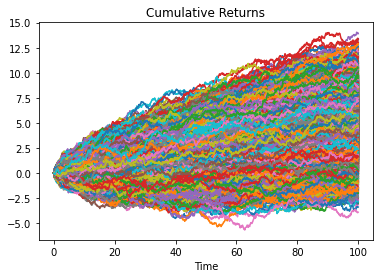

In [16]:
# Warm-up Exercise

np.random.seed(100)
n_paths = 10000
n_steps = 1000

mu = .05  # In the context of our exercise, think of this as index returns
sigma = .25  # and think of this as index vol
T = 100  # discretization of steps
T_vec, dt = np.linspace(0, T, n_steps, retstep=True)  # retstep is spacing between samples, i.e T / (steps-1)

x0 = np.zeros((n_paths, 1))  # initialize array
increments = stats.norm.rvs(loc=mu*dt, scale=np.sqrt(dt)*sigma, size=(n_paths, n_steps-1))  # setup motion
full_path = np.concatenate((x0, increments), axis=1)
x = np.cumsum(full_path, axis=1)  # accumulate paths

print(f"Max returns: {x.max()*100:.2f}%\nMean returns: {x.mean()*100:.2f}%")
x_end = x[:, -1]  # final obs in path

# plot
plt.plot(T_vec, x.T)
plt.title("Cumulative Returns")
plt.xlabel("Time")
plt.show();

### Scenario Analysis
Now we will get into the scenario analysis. In this example, we will explore the effects that scaling future volatility up/down 10% would have on our probability of breaking the lower strike. Continuing to use the credit spread as an example, since we are selling options ("selling premium"), two things would happen in an ideal world: volatility would decrease, and the price would move in the opposite direction of the strikes. Note that in our example of trading a short put spread on the SPY, an increase in price is likely to fulfil both of these criteria: for the most part volatility and price are inversely related -- but not always!

In [17]:
ticker = "SPY"
vol_window = 63

spot = si.get_live_price(ticker)
hist = ticker_history(ticker, window=vol_window, days_offset=365*10)
sigma = hist.iloc[-1]["annualized_vol"]

long_opt = puts.loc[puts["long_diff"] == puts["long_diff"].min()]
short_opt = puts.loc[puts["delta_diff"] == puts["delta_diff"].min()]

# generate simulated future prices
future_prices = mc_asset_price(spot, sigma=sigma, r=strat.r, t=strat.t, q=strat.q, n_paths=50000)

# find out how often the simulated prices fall below our current short strike price
price_below_short = np.where(future_prices < float(short_opt["strike"]), 1, 0)
price_below_long = np.where(future_prices < float(long_opt["strike"]), 1, 0)
pct_below_short = np.sum(price_below_short) / price_below_short.shape[0]
pct_below_long = np.sum(price_below_long) / price_below_long.shape[0]
print(f"Percent of time simulated prices fall below short position: {pct_below_short*100:.2f}%")
print(f"Percent of time simulated prices fall below long position: {pct_below_long*100:.2f}%")

Percent of time simulated prices fall below short position: 11.86%
Percent of time simulated prices fall below long position: 3.62%


In [18]:
# Repeat for high-vol scenario
future_prices = mc_asset_price(spot, sigma=sigma*1.1, r=strat.r, t=strat.t, q=strat.q, n_paths=50000)
price_below_short = np.where(future_prices < float(short_opt["strike"]), 1, 0)
price_below_long = np.where(future_prices < float(long_opt["strike"]), 1, 0)
pct_below_short = np.sum(price_below_short) / price_below_short.shape[0]
pct_below_long = np.sum(price_below_long) / price_below_long.shape[0]
print(f"Percent of time simulated prices fall below short position: {pct_below_short*100:.2f}%")
print(f"Percent of time simulated prices fall below long position: {pct_below_long*100:.2f}%")

Percent of time simulated prices fall below short position: 14.27%
Percent of time simulated prices fall below long position: 5.14%


In [19]:
# Repeat for low-vol scenario
future_prices = mc_asset_price(spot, sigma=sigma*.9, r=strat.r, t=strat.t, q=strat.q, n_paths=50000)
price_below_short = np.where(future_prices < float(short_opt["strike"]), 1, 0)
price_below_long = np.where(future_prices < float(long_opt["strike"]), 1, 0)
pct_below_short = np.sum(price_below_short) / price_below_short.shape[0]
pct_below_long = np.sum(price_below_long) / price_below_long.shape[0]
print(f"Percent of time simulated prices fall below short position: {pct_below_short*100:.2f}%")
print(f"Percent of time simulated prices fall below long position: {pct_below_long*100:.2f}%")

Percent of time simulated prices fall below short position: 9.24%
Percent of time simulated prices fall below long position: 2.31%


In [20]:
# Finally, lets check how frequently current volatility has occured in the past ~10 years
mean_vol = np.mean(hist["annualized_vol"])
below_current_sigma = np.where(hist["annualized_vol"] < sigma, 1, 0)
pct_below_sigma = np.sum(below_current_sigma) / below_current_sigma.shape[0]
print(f"Percent of time volatility is lower than now: {pct_below_sigma*100:.2f}%")

Percent of time volatility is lower than now: 33.51%


<a id='conclusion'></a>

## Analysis Conclusion
As you can see, our chances of breaching the strikes increases as we scale vol up and decreases as we scale vol down, exactly what we expected. Not only that, but we can see that current volatility is relatively low compared to history. Thus, if one were to decide that the premium was not attractice, it would be prudent to hold out until a higher-vol period. However, this does come at a cost if the capital that would be used for options trading is sitting in cash! 

Some monte carlo distribution visualizations are plotted below. Our previous code is also defined as a function that allows for easier manipulation of parameters

Mean rolling volatility: 14.69%


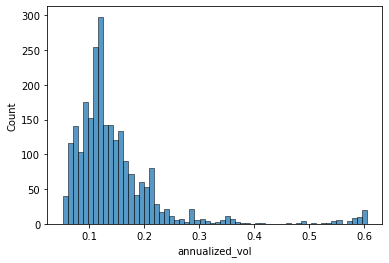

In [21]:
print(f"Mean rolling volatility: {hist['annualized_vol'].mean()*100:.2f}%")
sns.histplot(data=hist["annualized_vol"]);

Current price: 433.51
Mean future price: 433.51


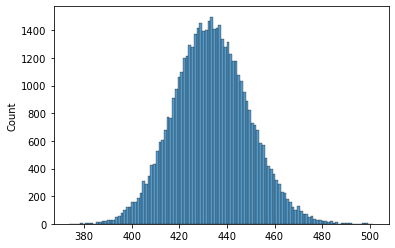

In [22]:
print(f"Current price: {spot:.2f}")
print(f"Mean future price: {future_prices.mean():.2f}")
sns.histplot(data=future_prices);

### Function Definition

In [23]:
# define above code as a function
def scenario_analysis(ticker, r, t, q, n_paths=50000, long=None, short=None, scale=.1):
    hist = ticker_history(ticker, window=63, days_offset=365*10)
    sigma = hist.iloc[-1]["annualized_vol"]
    spot = si.get_live_price(ticker)
    
    future_prices = mc_asset_price(spot, sigma=sigma, r=r, t=t, q=q, n_paths=50000)
    price_below_short = np.where(future_prices < float(short_opt["strike"]), 1, 0)
    price_below_long = np.where(future_prices < float(long_opt["strike"]), 1, 0)
    pct_below_short = np.sum(price_below_short) / price_below_short.shape[0]
    pct_below_long = np.sum(price_below_long) / price_below_long.shape[0]
    print(f"Percent of time simulated prices fall below short position: {pct_below_short*100:.2f}%")
    print(f"Percent of time simulated prices fall below long position: {pct_below_long*100:.2f}%\n")
    
    future_prices = mc_asset_price(spot, sigma=sigma*(1+scale), r=r, t=t, q=q, n_paths=50000)
    price_below_short = np.where(future_prices < float(short_opt["strike"]), 1, 0)
    price_below_long = np.where(future_prices < float(long_opt["strike"]), 1, 0)
    pct_below_short = np.sum(price_below_short) / price_below_short.shape[0]
    pct_below_long = np.sum(price_below_long) / price_below_long.shape[0]
    print(f"Percent of time simulated prices fall below short position (high vol): {pct_below_short*100:.2f}%")
    print(f"Percent of time simulated prices fall below long position (high vol): {pct_below_long*100:.2f}%\n")
    
    future_prices = mc_asset_price(spot, sigma=sigma*(1-scale), r=r, t=t, q=q, n_paths=50000)
    price_below_short = np.where(future_prices < float(short_opt["strike"]), 1, 0)
    price_below_long = np.where(future_prices < float(long_opt["strike"]), 1, 0)
    pct_below_short = np.sum(price_below_short) / price_below_short.shape[0]
    pct_below_long = np.sum(price_below_long) / price_below_long.shape[0]
    print(f"Percent of time simulated prices fall below short position (low vol): {pct_below_short*100:.2f}%")
    print(f"Percent of time simulated prices fall below long position (low vol): {pct_below_long*100:.2f}%\n")
    
    mean_vol = np.mean(hist["annualized_vol"])
    below_current_sigma = np.where(hist["annualized_vol"] < sigma, 1, 0)
    pct_below_sigma = np.sum(below_current_sigma) / below_current_sigma.shape[0]
    print(f"Percent of time volatility is lower than now: {pct_below_sigma*100:.2f}%")
    
    return hist

In [24]:
hist = scenario_analysis(ticker, r=strat.r, t=strat.t, q=strat.q, n_paths=50000)

Percent of time simulated prices fall below short position: 11.79%
Percent of time simulated prices fall below long position: 3.62%

Percent of time simulated prices fall below short position (high vol): 14.32%
Percent of time simulated prices fall below long position (high vol): 5.27%

Percent of time simulated prices fall below short position (low vol): 9.38%
Percent of time simulated prices fall below long position (low vol): 2.25%

Percent of time volatility is lower than now: 33.51%


## Thank you for walking through this project! Please reach out with any questions, comments, or feedback.